In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/MyDrive/Papers/superCon

Mounted at /content/drive
/content/drive/MyDrive/Papers/superCon


In [ ]:
import torch
print('Cuda State: {}'.format(torch.cuda.is_available()))
!nvidia-smi

Cuda State: True
Fri Jan 14 03:41:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                       

In [ ]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import math
import time
from torch.autograd import Variable
import copy
import random
import os
import csv
import pandas as pd
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
from FineTunedModel import FineTunedModel, grad_block 
from utils import BatchSampler,pad_to_same
# from torch.utils.tensorboard import SummaryWriter

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
SEED = 126
PAD_NUM = 0
BATCH_SIZE = 8
LEARNING_RATE = 2.5e-4
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings("ignore", category=UserWarning) 

In [ ]:
dataset_path = "./labels.csv"
coord_path = "./coordinates.npy"
data_path = "./molecule.npy"
lattice_path = "./lattice_new.npy"

mol = np.load(file=data_path, allow_pickle=True)
labels = pd.read_csv(dataset_path)
coords = np.load(file=coord_path, allow_pickle=True)
coords512 = np.load('./512coords.npy', allow_pickle=True)
lattice = np.load(file=lattice_path, allow_pickle=True)
labels = labels["supercon"][:].values


In [ ]:
sp_mol = mol[labels == 1]
sp_coords512 = coords512[labels == 1]
sp_lattice = lattice[labels == 1]
sp_labels = labels[labels == 1]
sp_coords = coords[labels == 1]

print(sp_mol.shape, sp_labels.shape, sp_coords512.shape, sp_lattice.shape)

(421,) (421,) (421,) (421, 9)


In [ ]:
del_list = []
for i in range(len(sp_mol)):
  if len(sp_mol[i]) == 1:
    del_list.append(i)
  
sp_mol = np.delete(sp_mol, del_list)
sp_labels = np.delete(sp_labels, del_list)
sp_coords512 = np.delete(sp_coords512, del_list)
sp_lattice = np.delete(sp_lattice, del_list, axis=0)
sp_coords = np.delete(sp_coords, del_list)

print(sp_mol.shape, sp_labels.shape, sp_coords512.shape, sp_lattice.shape)

(406,) (406,) (406,) (406, 9)


In [ ]:
SAMPLE_NUM = sp_labels.sum()
grad_storage = np.zeros(shape=(94, SAMPLE_NUM), dtype=np.float32)
print(grad_storage.shape)

(94, 406)


In [ ]:
fineTuneModel = FineTunedModel(num_layer=10)
model_dic = torch.load("./10LModel.pt")
fineTuneModel.load_state_dict(model_dic)
fineTuneModel.cuda()
fineTuneModel.eval()

In [ ]:
def grad_sample(NOW_MOLECULE):
  batch_index = [NOW_MOLECULE]
  atom_index_data = pad_to_same(sp_mol[batch_index], PAD_NUM).long().cuda()
  coords_data = sp_coords512[batch_index]
  lattice = torch.tensor(sp_lattice[batch_index],dtype=torch.float32).cuda()
  lattice.requires_grad_()

  mask_for_set2set = (atom_index_data == PAD_NUM).type(torch.uint8)
  mask = 1 - (atom_index_data == PAD_NUM).float()

  pred = fineTuneModel(atom_index_data, coords_data, lattice, mask, mask_for_set2set)

  pred_max = pred[1]
  pred_max.backward()
  
  return grad_block[-1], lattice.grad

In [ ]:
def get_map512(NOW_MOLECULE):
  #relu = nn.ReLU()
  grad, lattice_grad = grad_sample(NOW_MOLECULE)
  single_grad = grad.squeeze()
  single_grad = torch.abs(single_grad)
  single_grad = single_grad.cpu()
  
  lattice_grad = lattice_grad.squeeze()
  lattice_grad = torch.abs(lattice_grad)
  lattice_grad = lattice_grad.cpu()
  
  return single_grad, lattice_grad

In [ ]:
grad_percent_storage = []
lattice_percent_storage = []

for NOW_MOLECULE in range(SAMPLE_NUM):
  single_grad, lattice_grad = get_map512(NOW_MOLECULE)
  grad_sum = single_grad.sum(axis=1)
  grad_sum /= grad_sum.sum()
  lattice_grad /= lattice_grad.sum()

  grad_percent_storage.append(grad_sum.numpy())
  lattice_percent_storage.append(lattice_grad.numpy())

  for i in range(len(sp_mol[NOW_MOLECULE])):
    atom = sp_mol[NOW_MOLECULE][i]
    grad_storage[atom, NOW_MOLECULE] += grad_sum[i].numpy()

grad_percent_storage = np.array(grad_percent_storage)
lattice_percent_storage = np.array(lattice_percent_storage)

In [ ]:
def print_accumulated_importance(sample_num):
  grad = grad_storage[:, sample_num]
  print("\n\nVisulization for NO.{}: \n{}".format(sample_num, sp_mol[sample_num]))
  print(np.round(grad_percent_storage[sample_num], 3))
  for i in range(len(grad)):
    if grad[i]>0:
      print("Element {} contributes {} percentage".format(i, grad[i]))
  
  print("\nLattice percentage: \n", np.round(lattice_percent_storage[sample_num], 3))

In [ ]:
def visualize_sample(sample_num):
  sample_map, _ = get_map512(sample_num)
  plt.figure(sample_num, dpi=100)
  plt.title('NO.'+str(sample_num))
  sns.heatmap(sample_map.numpy(), cmap='mako')
  print_accumulated_importance(sample_num)
  #time.sleep(3)

In [ ]:
'''
for i in range(10):
  visualize_sample(i)
'''

'\nfor i in range(10):\n  visualize_sample(i)\n'

# New Section

In [ ]:
np.save('./grad_storage.npy', grad_storage) 
np.save('./grad_percent_storage.npy', grad_percent_storage) 
np.save('./lattice_percent_storage.npy', lattice_percent_storage) 

np.save('./sp_mol.npy', sp_mol) 
np.save('./sp_lattice.npy', sp_lattice) 
np.save('./sp_coords512.npy', sp_coords512) 
np.save('./sp_coords.npy', sp_coords)
np.save('./sp_labels.npy', sp_labels)

In [ ]:
def pred_sample(NOW_MOLECULE, lattice_changed):
  batch_index = [NOW_MOLECULE]
  atom_index_data = pad_to_same(sp_mol[batch_index], PAD_NUM).long().cuda()
  coords_data = sp_coords512[batch_index]
  lattice = torch.tensor(lattice_changed, dtype=torch.float32).cuda()

  mask_for_set2set = (atom_index_data == PAD_NUM).type(torch.uint8)
  mask = 1 - (atom_index_data == PAD_NUM).float()

  pred = fineTuneModel(atom_index_data, coords_data, lattice, mask, mask_for_set2set)
  pred_max = nn.Softmax()(pred)[1]
  
  return pred_max.item()

In [ ]:
#vol_list = []
def change7(MOL_CHANGE):
  #print(MOL_CHANGE)
  flag = 1
  prob_list = []
  lattice_change = sp_lattice[MOL_CHANGE].copy()
  #print(np.round(pred_sample(MOL_CHANGE, lattice_change), 2))

  for i in range(21):
    lattice_change[7] += 1
    #print(lattice_change[7])
    prob = pred_sample(MOL_CHANGE, lattice_change)
    if prob<0.5 and flag:
      vol = np.array([lattice_change[:3], lattice_change[3:6], lattice_change[6:9]])
      vol_list.append(np.linalg.det(vol))
      flag = 0
    prob_list.append(prob)

  prob_list = np.array(prob_list)
  plt.plot(prob_list)

[576.54 242.95  20.54  79.66  74.13 267.72  87.51 588.81 182.95 241.48
 570.42 266.22 301.16 141.23 195.57  85.06 578.21 542.93  80.36 131.46
 106.52]


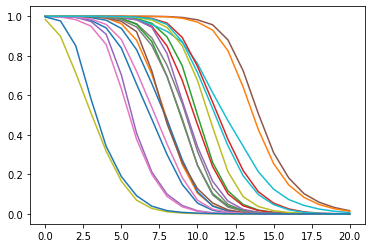

In [ ]:
vol_list = []
fe_list = [ 30,  60,  85, 127, 130, 155, 164, 167, 170, 178, 184, 205, 223,
            225, 311, 329, 336, 359, 367, 386, 391]

for i in fe_list:
  change7(i)
print(np.round(vol_list, 2))

[17.74 24.19 32.85]


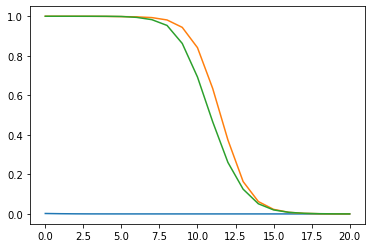

In [ ]:
vol_list = []
h_list = [146, 198, 215]
for i in h_list:
  change7(i)
print(np.round(vol_list, 2))

[140.31 233.61  48.73 187.96  98.82 290.36 199.16 100.44  59.2   35.1
 392.57 578.34]


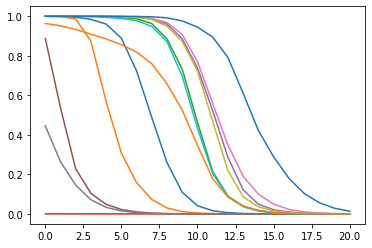

In [ ]:
vol_list = []
cu_list = [46, 63, 72, 90, 136, 231, 251, 335, 339, 347, 349, 379]
for i in cu_list:
  change7(i)
print(np.round(vol_list, 2))

[56 56 26 26 26 26 16 16 16 16 16 16]


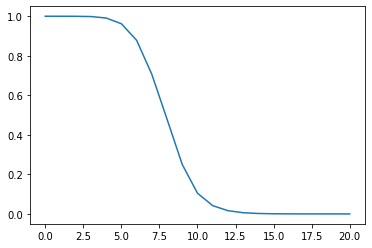

In [ ]:
show_num = 60
print(sp_mol[show_num])
change7(show_num)

[56 22 22 83 83  8]


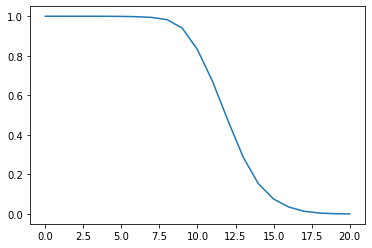

In [ ]:
show_num = 53
print(sp_mol[show_num])
change7(show_num)

[ 1  1 16]


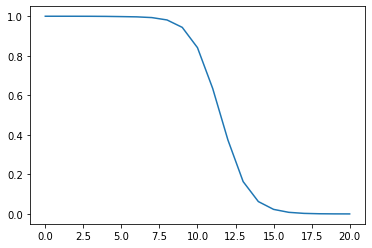

In [ ]:
show_num = 198
print(sp_mol[show_num])
change7(show_num)